## Explore the coverage of LMC and SMC

[utils](#utils)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db



In [267]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.facecolor'] = "w"


In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [6]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

### pixel id

In [7]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]


In [337]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)



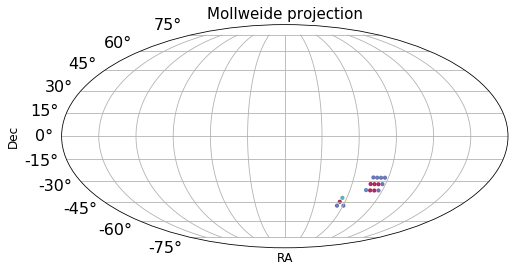

In [12]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 


slicer = ( df['inLMC'] | df['inSMC'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['TRIstarDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### evaulate by metric

by ra/dec

In [15]:
dblist_all[5]

'baseline_v1.5_10yrs.db'

In [16]:
class getDataMetric(metrics.BaseMetric):
    """
    extract data from database by column names, 
    combined with UniSlicer()
    """
    
    def __init__(self, colname=['expMJD', 'airmass'], **kwargs):
        self.colname = colname
        super().__init__(col=colname, metricDtype='object', **kwargs)
        
        
    def run(self, dataSlice, slicePoint=None):
        
        # return dataSlice directly
        result = dataSlice
        
        return result


In [75]:
dblist_all[5]

'baseline_v1.5_10yrs.db'

In [66]:

dbname = dblist_all[5]
opsdb = db.OpsimDatabase(dbpath+dbname)
#fltpair = ['r', 'i']

ipix_ms = ipix_LMC
nside = 16
#sqlconstraint = 'proposalId=1' # for wfd
sqlconstraint = 'note not like %DD%' # for wfd


if ipix_ms!=None:
    # use UserPointsSlicer for minisurvey
    ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
else:
    # use HealpixSlicer 
    slicer = slicers.HealpixSlicer(nside=nside)

metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter'])
#slicer = slicers.UniSlicer()
#slicer = slicers.HealpixSlicer(nside=16)

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()



Querying database SummaryAllProps with no constraint for columns ['filter', 'night', 'fieldRA', 'fiveSigmaDepth', 'observationStartMJD', 'fieldDec'].
Found 2229448 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [67]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [74]:
df.head(5)

,filter,night,fieldRA,fiveSigmaDepth,observationStartMJD,fieldDec
0,y,490,73.636371,21.820087,60337.174907,-64.988528
1,r,3028,74.691074,23.997651,62851.042709,-65.154824
2,r,3028,74.691074,24.019588,62851.040579,-65.154824
3,z,1884,74.486705,23.012840,61719.237658,-65.103988
4,i,3375,73.945581,23.358042,63197.265176,-65.066818


In [45]:
ipix_LMC

[2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]

In [69]:
pa = RADec2pix(nside=nside, ra=df['fieldRA'].values, dec=df['fieldDec'].values)
np.unique(pa)

array([2934, 2934, 2934, ..., 2967, 2967, 2967])

### evaulate by sql

precisely by pixid

In [282]:
def get_df_opsim(cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note',
            sqlstr = None, ipix_MS=[], nside=16):
    
    #cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note'
    #sqlstr = None
    
    opsim_MS = {}
    for dbname in dblist_all:
        #dbname = dblist_all[6]
        df = get_cols(dbfile=dbpath + dbname, cols=cols, lim=sqlstr)
        # get healpix Ids
        df = get_pixId(df, nside=nside)
        # get fields for LMC 
        df_MS = df[ np.isin(df['pixId'], ipix_MS) ].copy()
        
        df_MS['db'] = dbname 
        opsim_MS[dbname] = df_MS
    df = pd.concat(opsim_MS, ignore_index=True)
    
    return df

    

In [283]:
df = get_df_opsim(cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note',
            sqlstr = "note not like '%DD%'", ipix_MS=ipix_SMC, nside=16)
#df.to_csv("./data/df_opsim_LMC.csv", index=False)
df.to_csv("./data/df_opsim_SMC.csv", index=False)

connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/agnddf_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/alt_dust_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/baseline_2snaps_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/baseline_samefilt_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDe

connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/footprint_stuck_rollingv1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/goodseeing_gi_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/goodseeing_gri_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/goodseeing_griz_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/goodseeing_gz_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fie

connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/wfd_depth_scale0.80_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/wfd_depth_scale0.85_noddf_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/wfd_depth_scale0.85_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/wfd_depth_scale0.90_noddf_v1.5_10yrs.db 
 SELECT night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note FROM SummaryAllProps where note not like '%DD%'
connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/wfd_depth_scale0.90_v1.5_10yrs.db 
 SELECT night, observation

In [528]:
df = pd.read_csv("./data/df_opsim_LMC.csv")
#df = pd.read_csv("./data/df_opsim_SMC.csv")

In [529]:
df.pixId.unique()

array([2992, 2965, 2934, 2899, 2900, 2935, 2966, 2993, 2994, 2901, 2967,
       2936])

In [530]:
df.head()

,night,observationStartMJD,fieldRA,filter,fieldDec,proposalId,note,pixId,db
0,1,59854.361200,70.657753,z,-74.290475,0,greedy,2992,agnddf_v1.5_10yrs.db
1,1,59854.361614,74.737047,z,-71.425596,0,greedy,2965,agnddf_v1.5_10yrs.db
2,1,59854.362026,69.343271,z,-69.260527,0,greedy,2965,agnddf_v1.5_10yrs.db
3,1,59854.362440,72.757448,z,-66.435051,0,greedy,2934,agnddf_v1.5_10yrs.db
4,1,59854.362862,71.435003,z,-61.423513,1,greedy,2899,agnddf_v1.5_10yrs.db


#### rank by number of visits

In [466]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']



In [531]:
bydic = {
    "observationStartMJD": "count",
    "fieldRA" : "mean",
    "fieldDec": "mean",
    "proposalId" : "mean",
    
}
df_wfd = df[df.proposalId==1].groupby(by=['db', 'filter'], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv"}).set_index('db')

df_all = df.groupby(by=['db', 'filter'], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv"}).set_index('db')


In [532]:
# wfd
df_Nv_wfd = pd.DataFrame()
df_Nv_all = pd.DataFrame()

df_Nv_wfd['db'] = dblist_all
df_Nv_all['db'] = dblist_all

df_Nv_wfd = df_Nv_wfd.set_index('db')
df_Nv_all = df_Nv_all.set_index('db')


for f in filters:
    #print(f)
    df_Nv_wfd[f] = df_wfd[ df_wfd['filter'] == f ].Nv
    df_Nv_all[f] = df_all[ df_all['filter'] == f ].Nv

df_Nv_wfd['prop'] = 'wfd'
df_Nv_all['prop'] = 'all'


In [533]:
df_Nv = pd.concat([df_Nv_wfd, df_Nv_all])
df_Nv = df_Nv.reset_index()

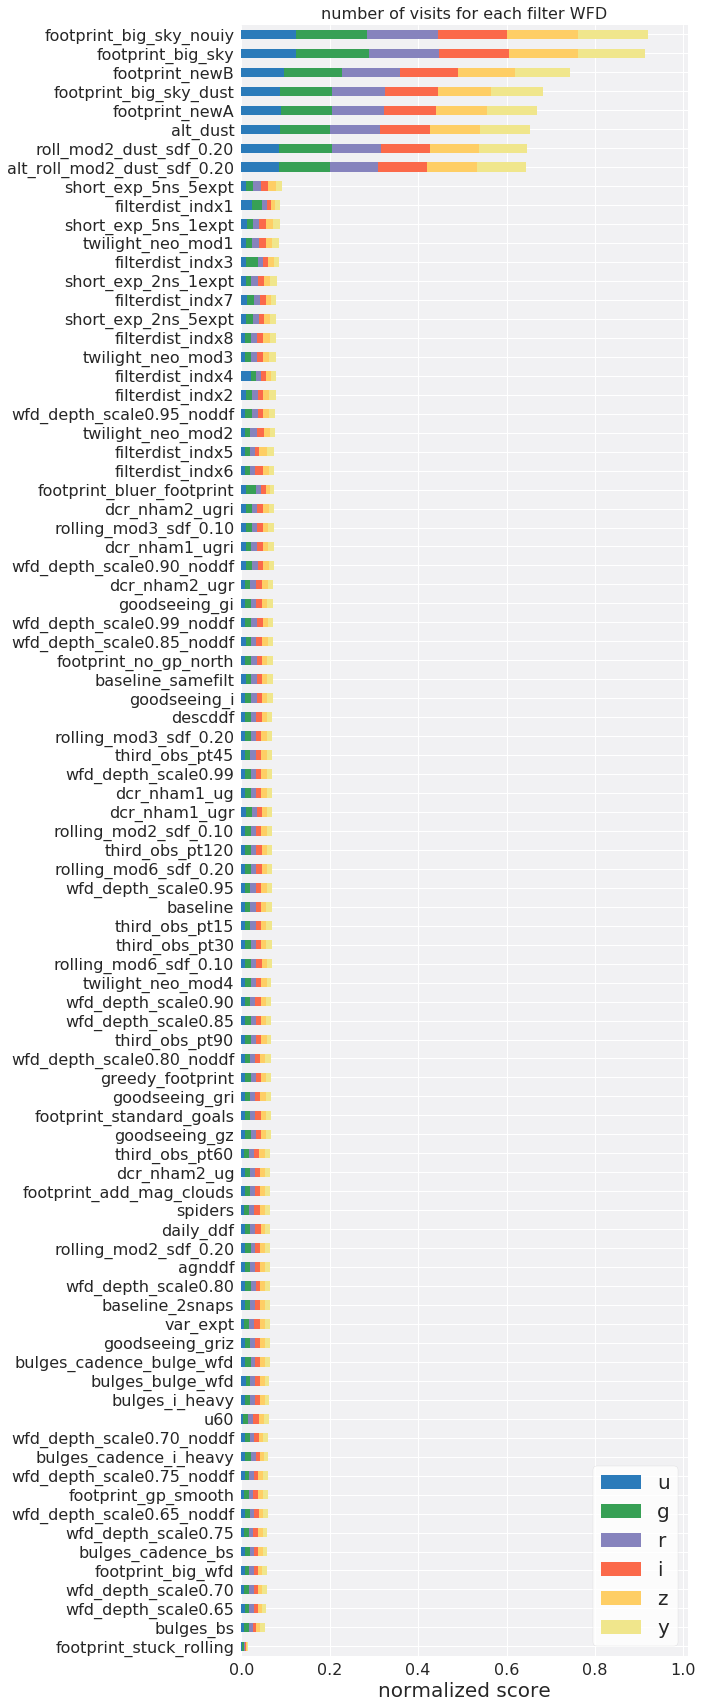

In [534]:
df_norm = get_df_norm(df=df_Nv, cols=filters)

title = 'number of visits for each filter WFD'
plot_barh(df_norm[df_norm.prop=='wfd'], filters, byfamily=False, savefig=None, title=title, cmap=get_mycmap(pairs='same') )


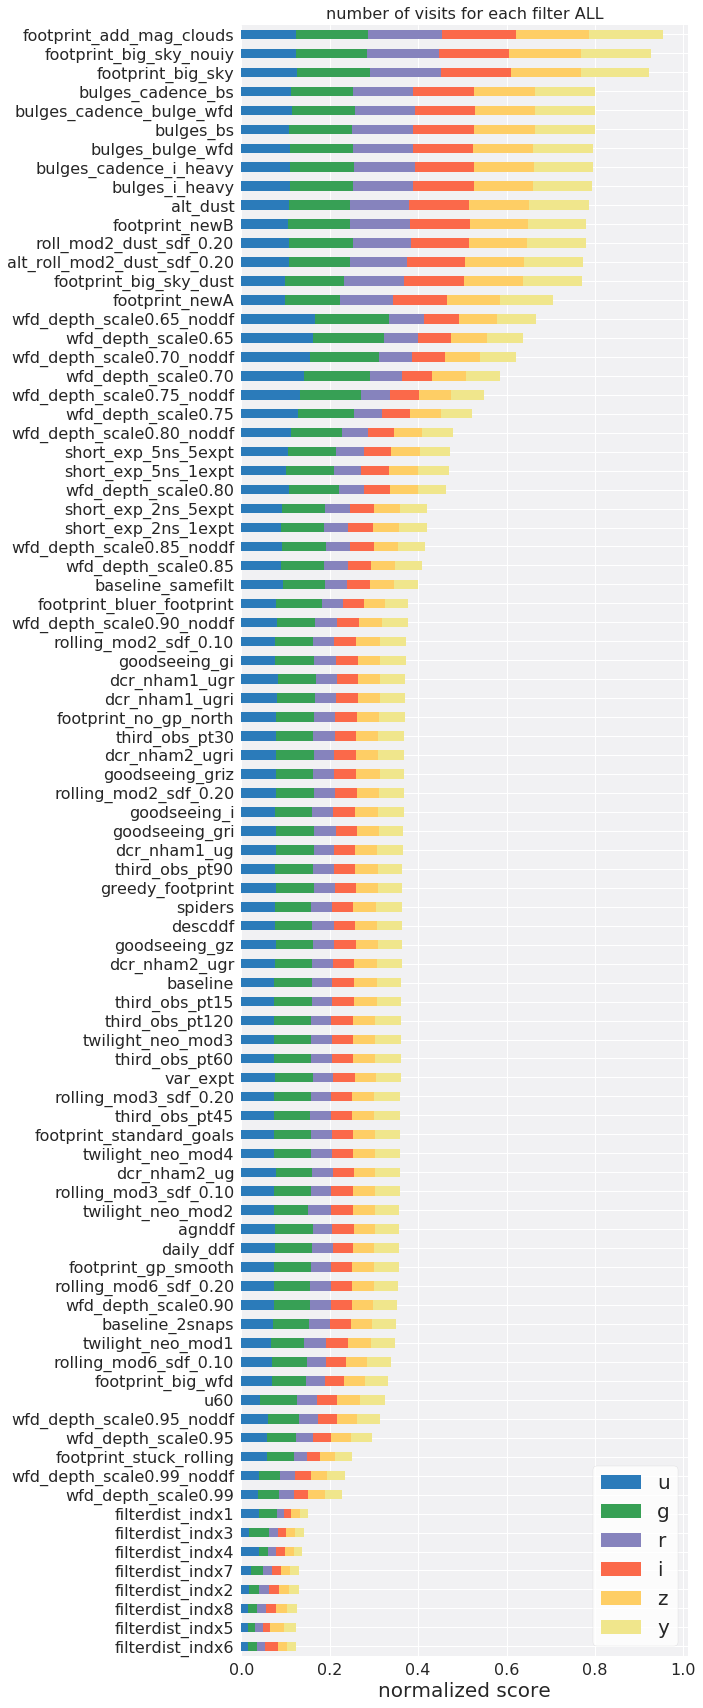

In [535]:
title = 'number of visits for each filter ALL'
plot_barh(df_norm[df_norm.prop=='all'], filters, byfamily=False, savefig=None, title=title, cmap=get_mycmap(pairs='same') )



#### rank by number of fields 

In [511]:
bydic = {
    "observationStartMJD": "count",
    "fieldRA" : "mean",
    "fieldDec": "mean",
    "proposalId" : "mean",
    'pixId': lambda x: len( np.unique(x) )
    
}
df_wfd = df[df.proposalId==1].groupby(by=['db', 'filter',], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv", "pixId": "nfields"}).set_index('db')

df_all = df.groupby(by=['db', 'filter'], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv", "pixId": "nfields"}).set_index('db')



In [512]:
df_all

,filter,Nv,fieldRA,fieldDec,proposalId,nfields
db,,,,,,
agnddf_v1.5_10yrs.db,g,269,12.976455,-71.882979,0.000000,5
agnddf_v1.5_10yrs.db,i,277,12.799433,-71.904428,0.000000,5
agnddf_v1.5_10yrs.db,r,256,12.802878,-71.706178,0.000000,5
agnddf_v1.5_10yrs.db,u,261,12.710587,-71.771796,0.000000,5
agnddf_v1.5_10yrs.db,y,360,13.352922,-71.768007,0.000000,5
agnddf_v1.5_10yrs.db,z,262,12.447518,-71.889914,0.000000,5
alt_dust_v1.5_10yrs.db,g,434,13.160812,-71.094578,0.758065,5
alt_dust_v1.5_10yrs.db,i,961,13.074517,-70.754817,0.815817,5
alt_dust_v1.5_10yrs.db,r,952,13.647936,-70.668153,0.834034,5


In [514]:
# wfd
df_Nf_wfd = pd.DataFrame()
df_Nf_all = pd.DataFrame()

df_Nf_wfd['db'] = dblist_all
df_Nf_all['db'] = dblist_all

df_Nf_wfd = df_Nf_wfd.set_index('db')
df_Nf_all = df_Nf_all.set_index('db')


for f in filters:
    df_Nf_wfd[f] = df_wfd[df_wfd['filter']==f]['nfields']

    df_Nf_all[f] = df_all[df_all['filter']==f]['nfields']


In [515]:
df_Nf_wfd['prop'] = 'wfd'
df_Nf_all['prop'] = 'all'

df_Nf = pd.concat([df_Nf_wfd, df_Nf_all])
df_Nf = df_Nf.reset_index()

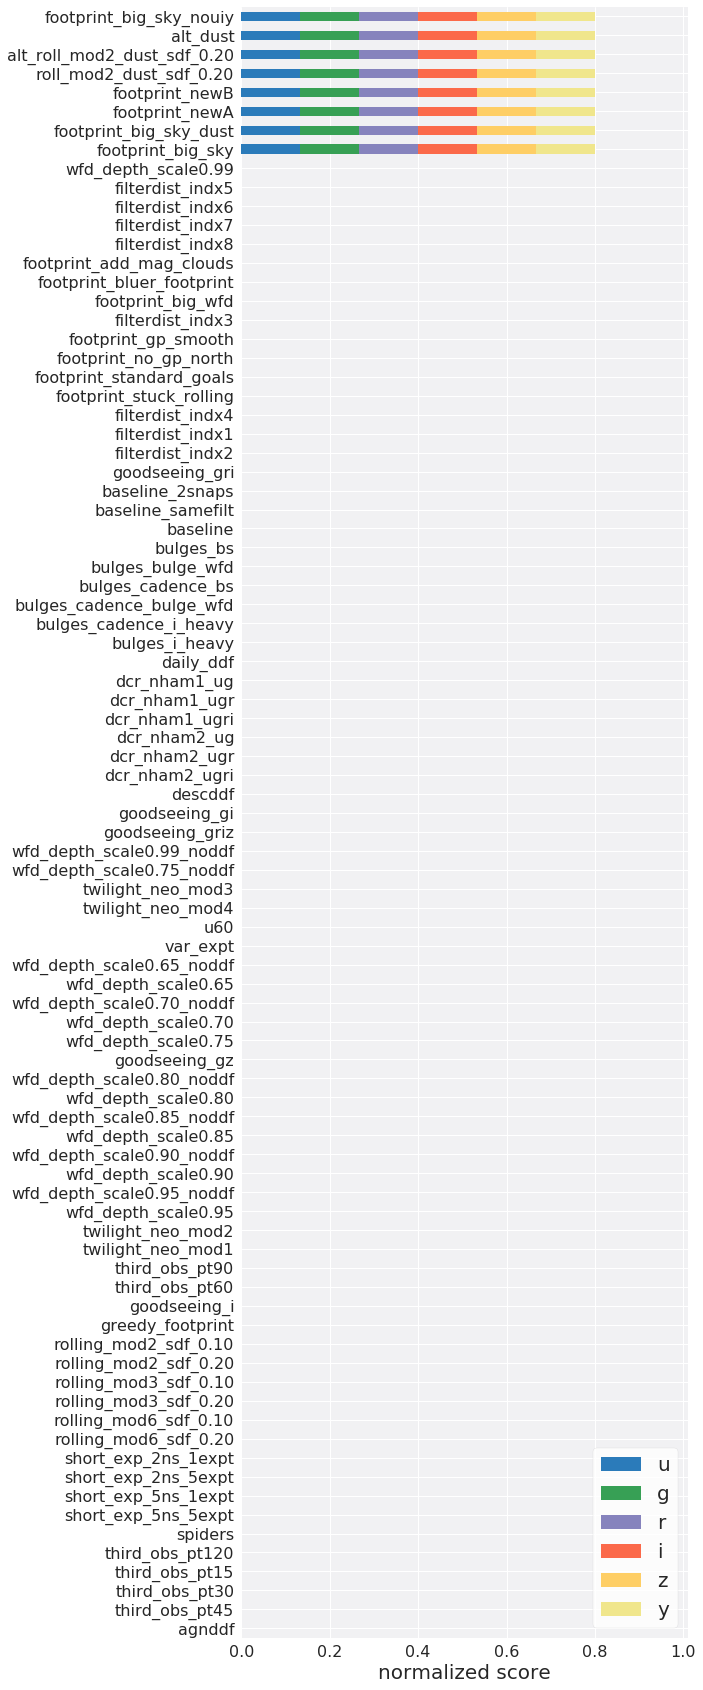

In [516]:
df_norm = get_df_norm(df=df_Nf, cols=filters)

plot_barh(df_norm[df_norm.prop=='wfd'], filters, byfamily=False, savefig=None, cmap=get_mycmap(pairs='same') )



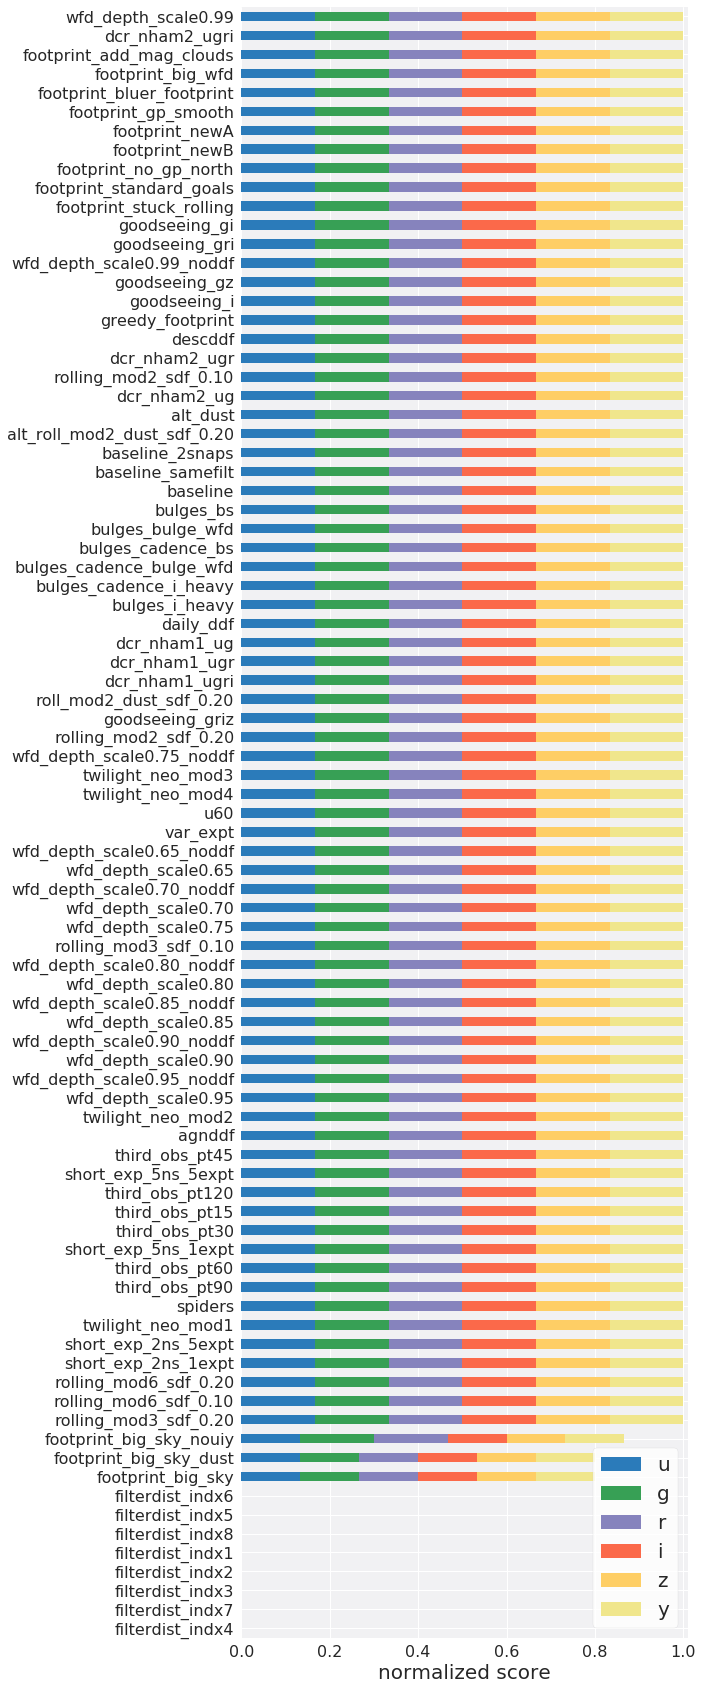

In [517]:
#df_norm = get_df_norm(df=df_Nf, cols=filters)

plot_barh(df_norm[df_norm.prop=='all'], filters, byfamily=False, savefig=None, cmap=get_mycmap(pairs='same') )



#### rank Nv in each field

In [519]:
bydic = {
    "observationStartMJD": "count",
    "fieldRA" : "mean",
    "fieldDec": "mean",
    "proposalId" : "mean",
    
}
df_wfd = df[df.proposalId==1].groupby(by=['db', 'pixId'], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv"}).set_index('db')

df_all = df.groupby(by=['db', 'pixId'], as_index=False)\
                            .agg(bydic).rename(columns={"observationStartMJD": "Nv"}).set_index('db')


In [521]:
df_wfd

,pixId,Nv,fieldRA,fieldDec,proposalId
db,,,,,
alt_dust_v1.5_10yrs.db,2960,1289,6.351537,-69.423380,1
alt_dust_v1.5_10yrs.db,2961,1224,19.245627,-69.410447,1
alt_dust_v1.5_10yrs.db,2988,578,9.738410,-71.339107,1
alt_dust_v1.5_10yrs.db,2989,553,23.772319,-71.269663,1
alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,2960,1221,6.294505,-69.436114,1
alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,2961,1191,19.200213,-69.432998,1
alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,2988,567,9.602915,-71.312159,1
alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,2989,584,23.741723,-71.204248,1
footprint_big_sky_dustv1.5_10yrs.db,2960,1342,6.212954,-69.416110,1


In [522]:
# wfd
df_Nf_wfd = pd.DataFrame()
df_Nf_all = pd.DataFrame()

df_Nf_wfd['db'] = dblist_all
df_Nf_all['db'] = dblist_all

df_Nf_wfd = df_Nf_wfd.set_index('db')
df_Nf_all = df_Nf_all.set_index('db')

for f in ipix_SMC:
    df_Nf_wfd[f] = df_wfd[df_wfd['pixId']==f]['Nv']
    df_Nf_all[f] = df_all[df_all['pixId']==f]['Nv']


df_Nf_wfd['prop'] = 'wfd'
df_Nf_all['prop'] = 'all'


In [524]:
df_Nf = pd.concat([df_Nf_wfd, df_Nf_all])
df_Nf = df_Nf.reset_index()

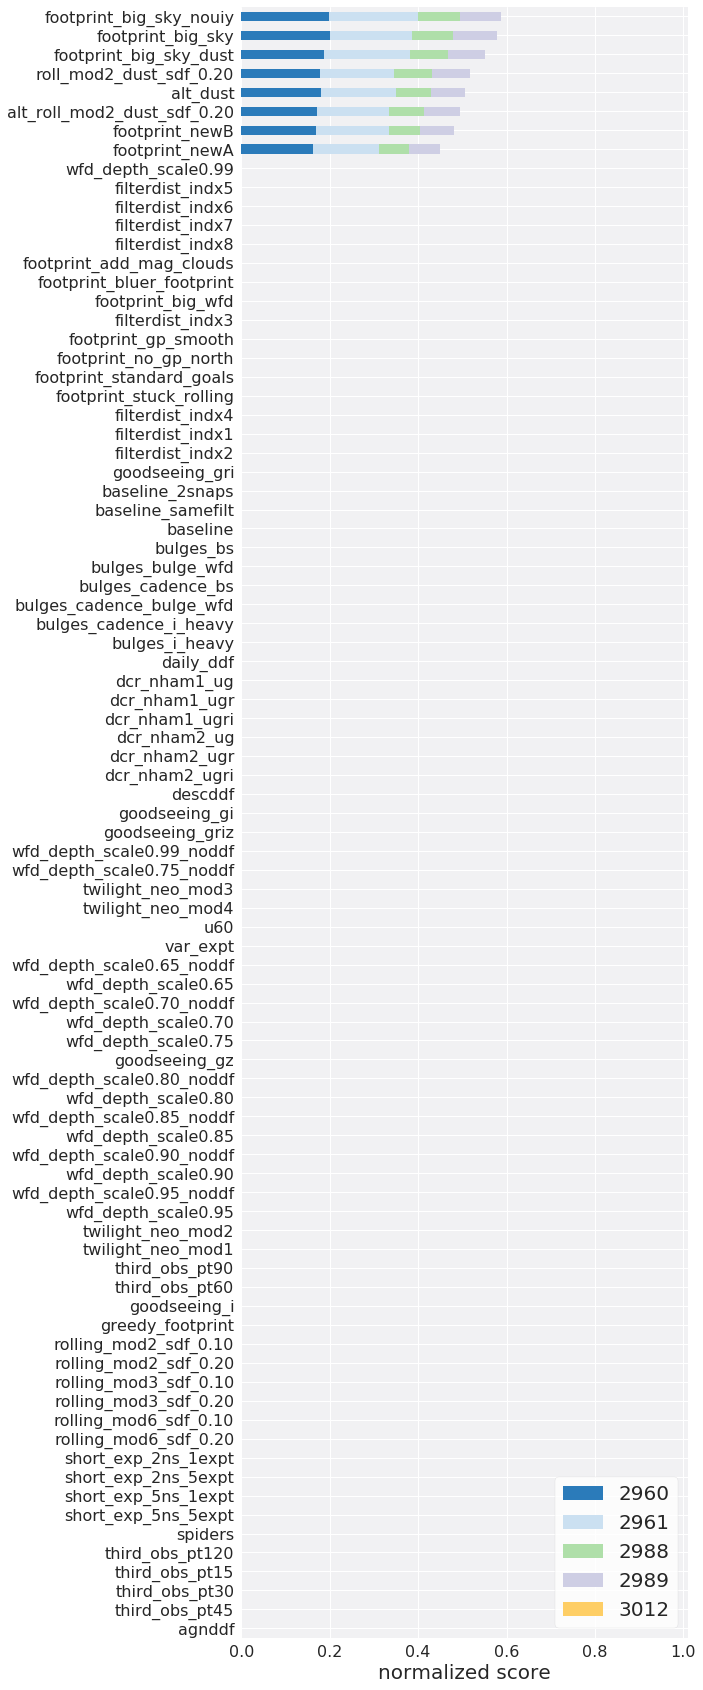

In [525]:
df_norm = get_df_norm(df=df_Nf, cols=ipix_SMC)

plot_barh(df_norm[df_norm.prop=='wfd'], colon=ipix_SMC, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )




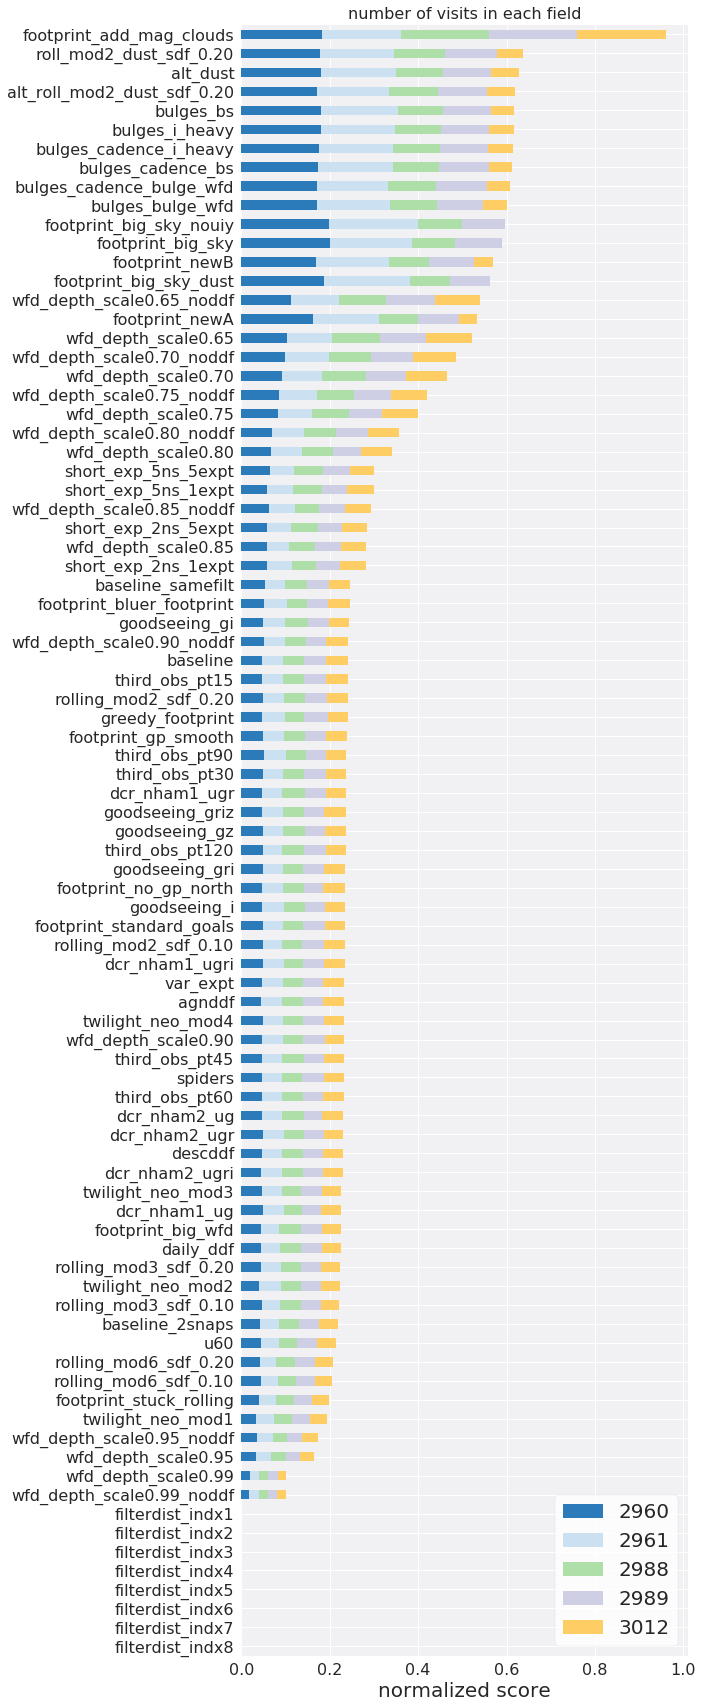

In [526]:
#df_norm = get_df_norm(df=df_Nf, cols=ipix_LMC)
title = 'number of visits in each field'
plot_barh(df_norm[df_norm.prop=='all'], colon=ipix_SMC, title=title, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )



### plot barh

In [306]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv'):
    """return normalized dataframe"""
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    df_new = df_fom[ ['db', 'prop'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col]) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new

In [176]:
def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [257]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap


### utils

In [9]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [79]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def get_pixId(df, nside=16):
    '''get pixId for each field'''
    pixId = RADec2pix(nside, ra=df['fieldRA'].values, dec=df['fieldDec'].values)
    df['pixId'] = pixId
    return df



In [76]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df